# Solving Maximum independent set problem with Rydberg atoms

In this example notebook, we shall demonstrate how to solve the maximum independent set (MIS) problem with Rydberg atoms. 

## Introduction to MIS

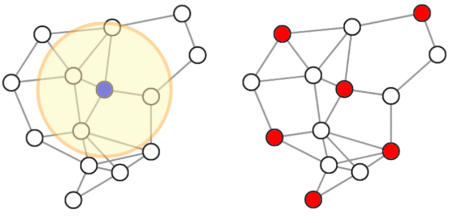

## Solving MIS with Rydberg atoms

We begin by importing the necessary packages.



In [3]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density

from braket.analog_hamiltonian_simulator.rydberg.rydberg_simulator import RydbergAtomSimulator

## Embed the graph into the Rydberg system

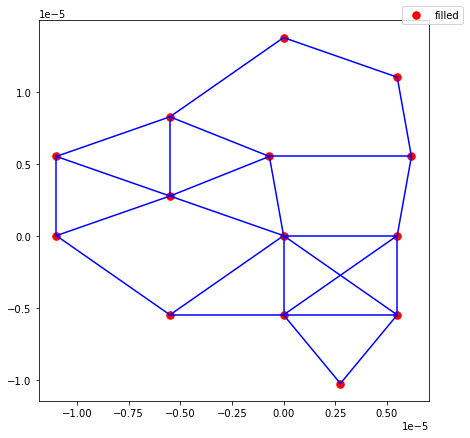

In [4]:
register = AtomArrangement()
a = 5.5e-6  # in meters 

coords = [
    [0, 5/2], [1, 2], [-1, 3/2], [-2, 1], [-1/8, 1],
    [9/8, 1], [-1, 1/2], [-2, 0], [0, 0], [1, 0],
    [-1, -1], [0, -1], [1, -1], [1/2, -(1+np.sqrt(3)/2)]]

coords = np.array(coords) * a

for coord in coords:
    register.add((coord[0], coord[1]))

show_register(register, blockade_radius=np.sqrt(2) * a)

In [5]:
amplitude_min = 0       
amplitude_max = 24e6

detuning_min = -24e6
detuning_max = 60e6

time_max = 4e-6  # s
time_ramp = 5e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = TimeSeries()
for t, v in zip(time_points, detuning_values):
    detuning.put(t, v)

phase = TimeSeries()
for t, v in zip(time_points, phase_values):
    phase.put(t, v)

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)

In [6]:
hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

ahs_program_ir = ahs_program.to_ir()

The input program is being validated.



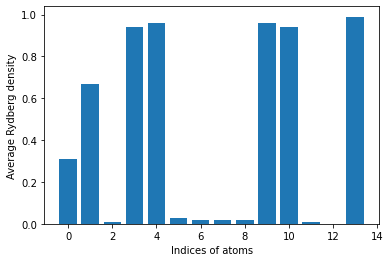

In [7]:
device = RydbergAtomSimulator()
result = device.run(ahs_program_ir, blockade_radius=np.sqrt(2) * a, shots=100)

show_final_avg_density(result)

## Local detuning

In [10]:
magnitude = TimeSeries()
magnitude.put(0, detuning_min)
magnitude.put(time_max, detuning_min)
    

# Note: Since all attributes of QuEra Aquila's driving field are uniform,
#       we pass the TimeSeries objects directly to the constructor.
#       This will contruct braket.ahs.field.Field objects with uniform patterns for the attributes.
shift = ShiftingField(
    Field(
            TimeSeries().put(0.0, detuning_min).put(time_max, detuning_min),
            Pattern([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        )
)

hamiltonian = Hamiltonian()
hamiltonian += drive 
hamiltonian += shift

ahs_program_with_shift = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

ahs_program_with_shift_ir = ahs_program_with_shift.to_ir()

The input program is being validated.



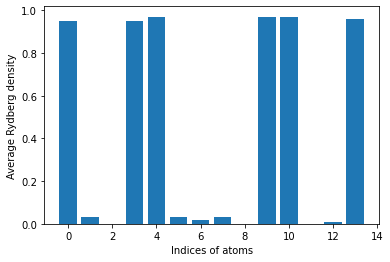

In [11]:
device = RydbergAtomSimulator()
result = device.run(ahs_program_with_shift_ir, blockade_radius=np.sqrt(2) * a, shots=100)

show_final_avg_density(result)